# Train a Hypergraph Network with Hyperedge Neurons (HNHN)

In this notebook, we will create and train a Hypergraph Network with Hyperedge Neurons in the hypergraph domain. This method is introduced in the paper [HNHN: Hypergraph Networks with Hyperedge Neurons](https://arxiv.org/abs/2006.12278) by Dong et al. We will use a benchmark dataset, CiteSeer, a collection of 1498 academic papers and 1107 authors, to do the task of node classification. There are 6 categories into which the papers are classified.

Each document is initially represented as a binary vector of length 3703, standing for a unique subset of the words within the papers, in which a value of 1 means the presence of its corresponding word in the paper.

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from topomodelx.nn.hypergraph.hnhn2_layer import HNHN2Layer
from topomodelx.nn.hypergraph.hnhn2 import HNHN2

from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit

If GPU's are available, we will make use of them. Otherwise, this will run on CPU.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Pre-processing

Here we download the dataset from the official repo of the paper. It contains initial representation of nodes, the incidence matrix and the category labels. The incidence matrix or $B_1$ is of shape $n_\text{nodes} \times n_\text{edges}$.

We also split the data into train and test splits according to the paper.

In [ ]:
! wget https://github.com/twistedcubic/HNHN/raw/master/data/citeseer6cls3703.pt

In [3]:
data = torch.load("citeseer6cls3703.pt")
dataset = Data(
    x=torch.from_numpy(data["paper_X"]).to(torch.float),
    incidence_1=torch.sparse_coo_tensor(
        indices=torch.LongTensor(data["paper_author"]).T,
        values=torch.ones(len(data["paper_author"]), dtype=torch.long),
    ),
    y=torch.LongTensor(data["classes"]),
)
train_test_splitter = RandomNodeSplit(num_test=0.85, num_val=0)
dataset = train_test_splitter(dataset).to(device)

# Train the Neural Network

We then specify the hyperparameters and construct the model, the loss, optimizer and a LR scheduler according to the paper.

In [5]:
in_features = 3703
hidden_features = 400
num_classes = 6
n_layers = 1
dropout_rate = 0.3
initial_lr = 0.04

model = HNHN2(
    in_features,
    hidden_features,
    dataset["incidence_1"],
    num_classes,
    n_layers,
    dropout_rate,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
loss_fn = torch.nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.51)

Now it's time to train the model, looping over the network for a low amount of epochs. We keep training minimal for the purpose of rapid testing.

In [6]:
train_y_true = dataset["y"][dataset["train_mask"]]
model.train()
for epoch in range(50):
    optimizer.zero_grad()
    y_pred_logits, _ = model(dataset["x"])
    loss = loss_fn(y_pred_logits[dataset["train_mask"]], train_y_true)
    loss.backward()
    optimizer.step()
    y_pred = y_pred_logits.argmax(dim=-1)
    print(
        f"Epoch: {epoch + 1} loss: {loss.item():.4f} acc: {accuracy_score(train_y_true, y_pred[dataset['train_mask']]):.2f}"
    )
    lr_scheduler.step()

Epoch: 1 loss: 1.7889 acc: 0.19
Epoch: 2 loss: 11.6347 acc: 0.41
Epoch: 3 loss: 67.6458 acc: 0.19
Epoch: 4 loss: 21.9118 acc: 0.19
Epoch: 5 loss: 7.5491 acc: 0.40
Epoch: 6 loss: 2.7203 acc: 0.46
Epoch: 7 loss: 25.5956 acc: 0.12
Epoch: 8 loss: 1.4068 acc: 0.66
Epoch: 9 loss: 0.4721 acc: 0.86
Epoch: 10 loss: 0.7964 acc: 0.86
Epoch: 11 loss: 0.3502 acc: 0.93
Epoch: 12 loss: 0.3431 acc: 0.95
Epoch: 13 loss: 0.5075 acc: 0.93
Epoch: 14 loss: 1.0124 acc: 0.83
Epoch: 15 loss: 0.2914 acc: 0.95
Epoch: 16 loss: 0.9682 acc: 0.89
Epoch: 17 loss: 0.2804 acc: 0.95
Epoch: 18 loss: 0.2231 acc: 0.97
Epoch: 19 loss: 0.6046 acc: 0.91
Epoch: 20 loss: 0.0786 acc: 0.98
Epoch: 21 loss: 0.2483 acc: 0.94
Epoch: 22 loss: 0.2452 acc: 0.93
Epoch: 23 loss: 0.2004 acc: 0.96
Epoch: 24 loss: 0.2019 acc: 0.95
Epoch: 25 loss: 0.0568 acc: 0.99
Epoch: 26 loss: 0.1139 acc: 0.98
Epoch: 27 loss: 0.0559 acc: 0.98
Epoch: 28 loss: 0.0248 acc: 0.99
Epoch: 29 loss: 0.0396 acc: 0.98
Epoch: 30 loss: 0.0560 acc: 0.98
Epoch: 31 loss:

We then evaluate the model against the test data.

In [7]:
model.eval()
with torch.no_grad():
    y_pred_logits, _ = model(dataset["x"])
test_y_true = dataset["y"][dataset["test_mask"]]
loss = loss_fn(y_pred_logits[dataset["test_mask"]], test_y_true)
print(f"Test loss: {loss.item():.4f}")
y_pred = y_pred_logits.argmax(dim=-1)
print(f"Test accuracy: {accuracy_score(test_y_true, y_pred[dataset['test_mask']]):.2f}")

Test loss: 10.8441
Test accuracy: 0.57


Finally, it's worth it to visualize the learned hidden representations after training the model.

/home/sadra-barikbin/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sadra-barikbin/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/sadra-barikbin/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sadra-barikbin/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'Test data')

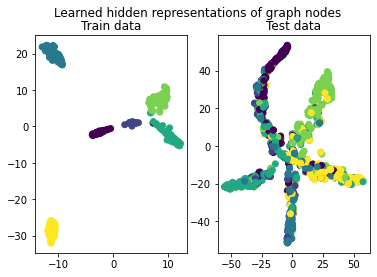

In [8]:
tsne = TSNE(n_components=2)
model.eval()
with torch.no_grad():
    x_0, _ = model.layers(model.to_hidden_linear(dataset["x"]))
x_0_train = tsne.fit_transform(x_0[dataset["train_mask"]])
x_0_test = tsne.fit_transform(x_0[dataset["test_mask"]])
f, (ax1, ax2) = plt.subplots(1, 2)
f.suptitle("Learned hidden representations of graph nodes")
ax1.scatter(x_0_train[:, 0], x_0_train[:, 1], c=dataset["y"][dataset["train_mask"]])
ax1.set_title("Train data")

ax2.scatter(x_0_test[:, 0], x_0_test[:, 1], c=dataset["y"][dataset["test_mask"]])
ax2.set_title("Test data")